# Transcriptomics visualizations
Now that we've used R to get the differentially expressed genes, we can do some visualizations of what those look like for different comparisons.

In [25]:
from os import listdir
from os.path import splitext, abspath
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
from tqdm import tqdm
from collections import defaultdict
import subprocess
import sys
sys.path.append('../utils/')
%load_ext autoreload
%autoreload 2
from get_arabidopsis_descriptions import get_arabidopsis_descriptions
from upsetplot import from_contents, plot
import warnings

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read in the data

In [2]:
datapath = '../data/deseq2_output/'
time_comparisons = {}
o2_comparisons = {}
for f in listdir(datapath):
    name = '_'.join(f.split('_')[:4])
    if f.split('_')[1] == 'vs':
        time_comparisons[name] = pd.read_csv(datapath+f)
    elif f.split('_')[1] == 'o2':
        o2_comparisons[name] = pd.read_csv(datapath+f)

In [3]:
time_comparisons.keys(), o2_comparisons.keys()

(dict_keys(['1h_vs_7h_2o2', '1h_vs_7h_40o2', '1h_vs_7h_21o2']),
 dict_keys(['1h_o2_40_21', '7h_o2_2_21', '1h_o2_2_21', '7h_o2_40_21']))

## Time comparisons
First, let's take a look at the distributions of the log fold change for the 1 hour vs. 7 hour comparisons.

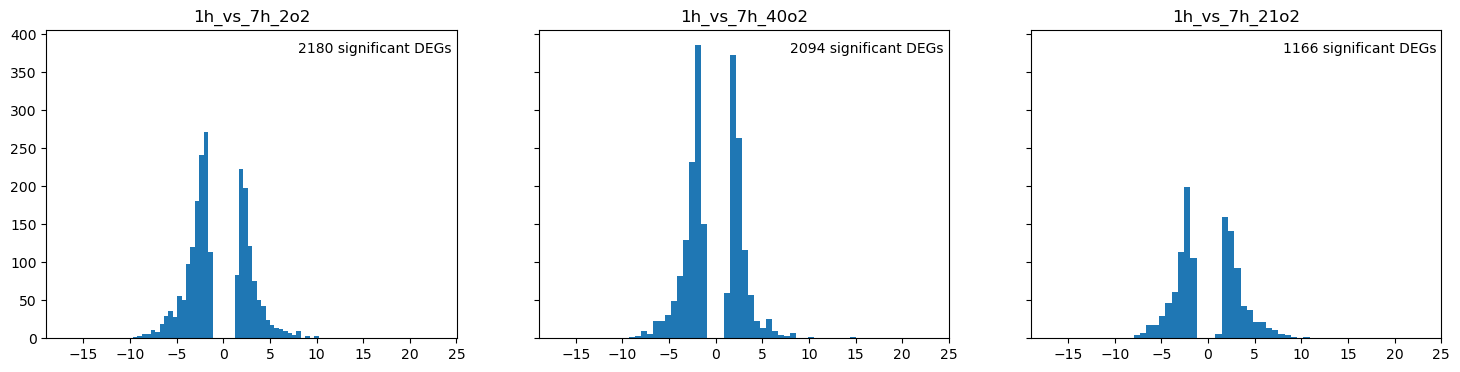

In [4]:
fig, axs = plt.subplots(1, len(time_comparisons), sharex=True, sharey=True, figsize=(len(time_comparisons)*6, 4))

for ax, comp in zip(axs, time_comparisons):
    ax.hist(time_comparisons[comp].log2FoldChange, bins=50)
    ax.set_title(comp)
    ax.text(8, 375, f'{len(time_comparisons[comp])} significant DEGs')

The presence of so many DEGs after 7 hours at ambient oxygen to me indicates that many of the DEGs we're seeing in the other conditions aren't related to the change in photorespiration as induced by the change in oxygen, but rather normal processed that change over the course of a day. What happens to these distributions if we remove the DEGs from 2% and 40% that are also found with the same directional change in 21%?

In [5]:
two_21_merged = pd.merge(time_comparisons['1h_vs_7h_2o2'], time_comparisons['1h_vs_7h_21o2'], left_on='gene_id', right_on='gene_id', suffixes=('_2o2', '_21o2'))
two_to_drop = two_21_merged[two_21_merged.log2FoldChange_2o2 * two_21_merged.log2FoldChange_21o2 > 0].gene_id
two_filtered_by_21 = time_comparisons['1h_vs_7h_2o2'][~time_comparisons['1h_vs_7h_2o2'].gene_id.isin(two_to_drop)].reset_index(drop=True)
two_filtered_by_21.shape

(1492, 7)

In [6]:
forty_21_merged = pd.merge(time_comparisons['1h_vs_7h_40o2'], time_comparisons['1h_vs_7h_21o2'], left_on='gene_id', right_on='gene_id', suffixes=('_40o2', '_21o2'))
forty_to_drop = forty_21_merged[forty_21_merged.log2FoldChange_40o2 * forty_21_merged.log2FoldChange_21o2 > 0].gene_id
forty_filtered_by_21 = time_comparisons['1h_vs_7h_40o2'][~time_comparisons['1h_vs_7h_40o2'].gene_id.isin(forty_to_drop)].reset_index(drop=True)
forty_filtered_by_21.shape

(1280, 7)

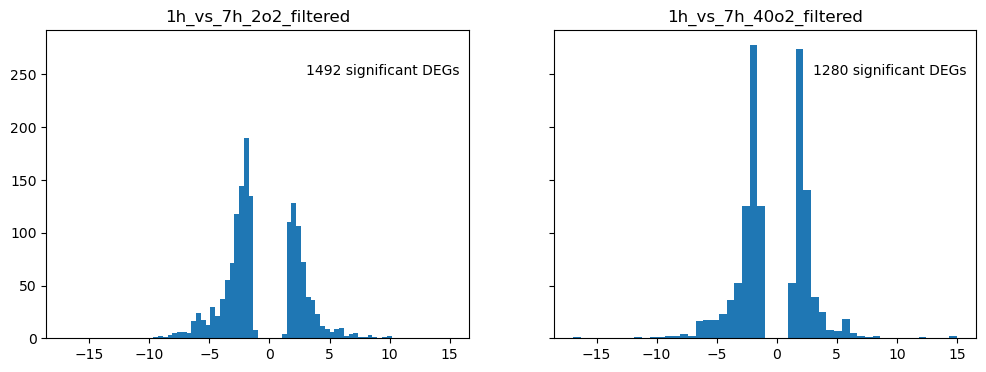

In [7]:
comps_filtered = {
    '1h_vs_7h_2o2_filtered': two_filtered_by_21,
    '1h_vs_7h_40o2_filtered': forty_filtered_by_21
}
fig, axs = plt.subplots(1, len(comps_filtered), sharex=True, sharey=True, figsize=(len(comps_filtered)*6, 4))

for ax, comp in zip(axs, comps_filtered):
    ax.hist(comps_filtered[comp].log2FoldChange, bins=50)
    ax.set_title(comp)
    ax.text(3, 250, f'{len(comps_filtered[comp])} significant DEGs')

That substantially reduces the number of genes we're interested in looking at. Now we can look at a volcano plot, which plots the log fold change against the p-value of the change:

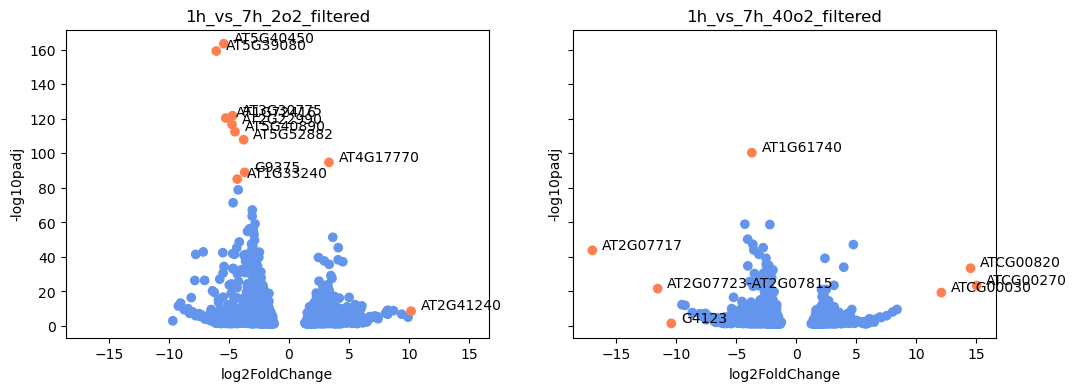

In [8]:
fig, axs = plt.subplots(1, len(comps_filtered), sharex=True, sharey=True, figsize=(len(comps_filtered)*6, 4))

for ax, comp in zip(axs, comps_filtered):
    x = comps_filtered[comp].log2FoldChange
    y = -np.log10(comps_filtered[comp].padj)
    colors = ['coral' if (abs(x_i) > 10 or y_i > 80) else 'cornflowerblue' for x_i, y_i in zip(x, y)]
    ax.scatter(x, y, c=colors)
    # Add gene name labels for the far out ones
    for i in range(len(x)):
        if colors[i] == 'coral':
            ax.annotate(comps_filtered[comp].loc[i, 'gene_id'], (x[i], y[i]), xytext=(x[i]+0.8, y[i]+0.8))

    ax.set_title(comp)
    ax.set_xlabel('log2FoldChange')
    ax.set_ylabel('-log10padj')

Generally speaking, we are interested in genes that have opposite responses at 2% vs. 40% oxygen, as the photorespiratory demands of those two conditions are opposite. Let's take a look at what genes fit that description for the hour comparisons:

In [9]:
two_forty = pd.merge(two_filtered_by_21, forty_filtered_by_21, left_on='gene_id', right_on='gene_id', suffixes=('_2o2', '_40o2'))

In [10]:
opposites_hour = two_forty[two_forty['log2FoldChange_2o2']*two_forty['log2FoldChange_40o2'] < 0]
opposites_hour.shape

(12, 13)

That gives us 12 genes, which is a very manageable number!

## Oxygen comparisons
Before we dive into the time comparison opposite behavior genes, let's look at the comparisons of each oxygen level at the two timepoints. We can then cross-reference the genes of interest that we find in order to narrow down our list even further. Let's start with the same basic visualizations as we did for the time comparisons:

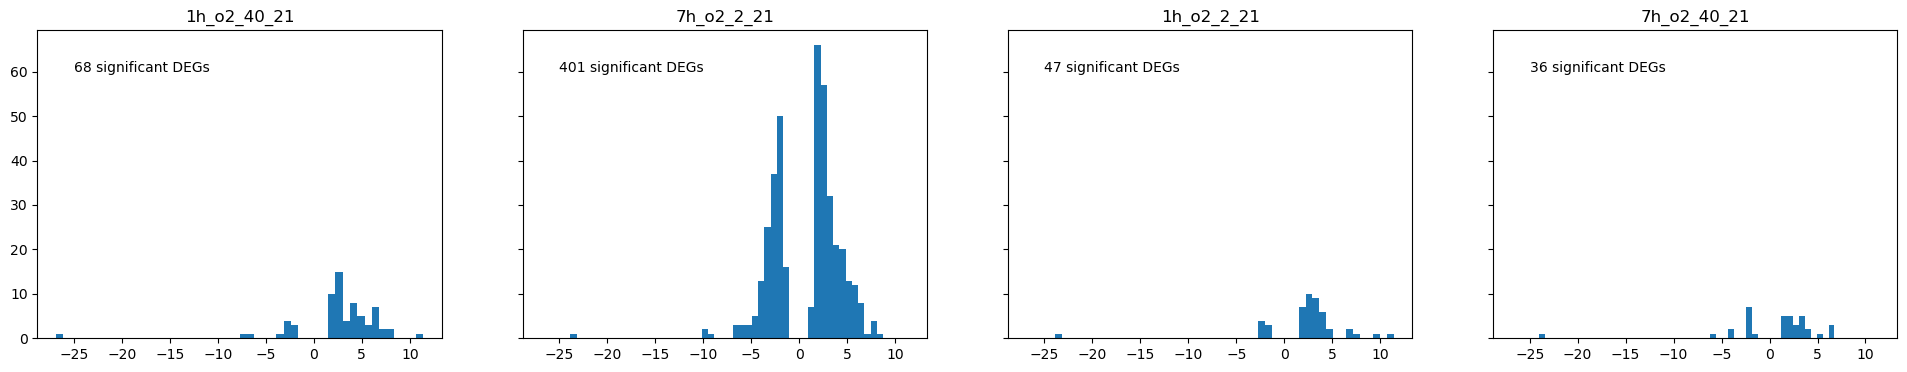

In [11]:
fig, axs = plt.subplots(1, len(o2_comparisons), sharex=True, sharey=True, figsize=(len(o2_comparisons)*6, 4))

for ax, comp in zip(axs, o2_comparisons):
    ax.hist(o2_comparisons[comp].log2FoldChange, bins=50)
    ax.set_title(comp)
    ax.text(-25, 60, f'{len(o2_comparisons[comp])} significant DEGs')

Now this is interesting; we have much more skewed distributions for these comparisons, and there are many fewer genes being differentially expressed in these comparisons. Interestingly, note that there are substantially more DEGs at 7 hours in the 2% samples; this is the condition that showed a return to ambient levels of phi2. As before, we're interested in genes that have opposite behaviors between 2% and 40%; abut I am also now curious about the large number of DEGs in 2% at 7 hours.

For the time comparisons, we made the assumption that DEGs at 21% oxygen that appeared in the 2% or 40% treatments could be removed because we're interested in the differences from the ambient condition. Similarly here, we could make the assumption that the 1 hour time point is more or less the same as ambient and remove those genes from the 7 hour timepoints. However, given that the oxygen groupings separated on the PCA at 1 hour, I am not sure this is a valid assumption. To put that assumption to the test, let's see how many DEGs are in common between the oxygen comparisons at 1 hour, regardless of their directionality. If the 1 hour timepoint isn't meaningful biologically, then I would expect that most of the DEGs are in common between the two conditions.

In [12]:
shared = set(o2_comparisons['1h_o2_2_21'].gene_id).intersection(o2_comparisons['1h_o2_40_21'].gene_id)
print(f'There are {len(shared)} genes in common  between the oxygen conditions at 1 hour. This represents {(len(shared)/len(o2_comparisons["1h_o2_2_21"]))*100:.2f}% '
     f'of the total DEGs for 2% oxygen at 1 hour, and {(len(shared)/len(o2_comparisons["1h_o2_40_21"]))*100:.2f}%  of the total DEGs for 40% oxygen at 1 hour.')

There are 15 genes in common  between the oxygen conditions at 1 hour. This represents 31.91% of the total DEGs for 2% oxygen at 1 hour, and 22.06%  of the total DEGs for 40% oxygen at 1 hour.


Ok so a reasonable proportion of them are in common (at least from the perspective of presence/absence), but it's less than 1/3rd for both conditions. I am therefore going to treat the 1 hour condition as having biologically meaningful expression differences as induced by the changes in oxygen. We'll therefore look at the genes that have opposite behaviors between the oxygen conditions for both timepoints separately, and then we can dig in and see if any of those DEGs are the same for the two timepoints in a given condition (the thought being that maybe something that starts having differential expression at 1 hour has stronger differential expression at 7 hours).

In [13]:
hour1 = pd.merge(o2_comparisons['1h_o2_2_21'], o2_comparisons['1h_o2_40_21'], left_on='gene_id', right_on='gene_id', suffixes=('_2o2', '_40o2'))
opposites_hour1 = hour1[hour1['log2FoldChange_2o2']*hour1['log2FoldChange_40o2'] < 0]

In [14]:
hour7 = pd.merge(o2_comparisons['7h_o2_2_21'], o2_comparisons['7h_o2_40_21'], left_on='gene_id', right_on='gene_id', suffixes=('_2o2', '_40o2'))
opposites_hour7 = hour7[hour7['log2FoldChange_2o2']*hour7['log2FoldChange_40o2'] < 0]

In [15]:
print(f'There are {len(opposites_hour1)} opposite-behavior DEGs at 1 hour, and {len(opposites_hour7)} at 7 hours.')

There are 0 opposite-behavior DEGs at 1 hour, and 5 at 7 hours.


That is way fewer than I expected! Firstly, this means that the genes in common between the two conditions at hour 1 are both regulated in the same direction. This actually supports the idea that there is not much biologically meaningful going on at 1 hour that's caused by the changes in oxygen; however, this analysis doesn't account for the greater portion of genes that the two conditions don't have in common.

## Time and Oxygen
There are also substantially fewer genes with opposite behavior at the 7 hour time point. Are any of these in common with our opposite behavior genes from the time comparison?

In [16]:
all_opposite = set(opposites_hour.gene_id).intersection(set(opposites_hour7.gene_id))
all_opposite

{'AT5G24490'}

Only one is in common; what is this gene? According to the [GO annotations in TAIR for this gene](https://www.arabidopsis.org/locus?name=AT5G24490#), the gene is involved in negative regulation of translational elongation and its gene product is located in the chloroplast. Is this potentially indicative of the fact that it's at the protein translational level where most of the important changes are taking place in response to oxygen? What directions does it go in the various conditions?

In [17]:
gene_of_interest = list(all_opposite)[0]
gene_of_interest_behaviors = {}
all_comparisons = time_comparisons
all_comparisons.update(o2_comparisons)
for comp, df in all_comparisons.items():
    try:
        gene_of_interest_behaviors[comp] = list(df[df['gene_id'] == gene_of_interest]['log2FoldChange'])[0]
    except IndexError:
        continue # Skips conditions where the gene doesn't appear

In [18]:
# Give some easier to parse labels for the plot
parsable_condition_names = {
    '1h_vs_7h_2o2': '1h vs. 7h\n2% oxygen',
    '1h_vs_7h_40o2': '1h vs. 7h\n40% oxygen',
    '7h_o2_2_21': '2% vs. 21%\n1 hour',
    '7h_o2_40_21': '40% vs. 21%\n1 hour'
}

Text(0.5, 1.0, 'Expression behavior of gene AT5G24490 across conditions where it appears')

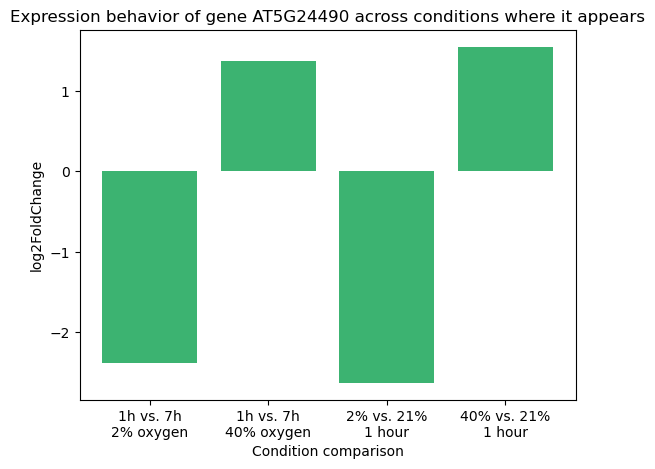

In [19]:
fig, ax = plt.subplots()

ax.bar([parsable_condition_names[k] for k in gene_of_interest_behaviors.keys()], gene_of_interest_behaviors.values(), color='mediumseagreen')
ax.set_xlabel('Condition comparison')
ax.set_ylabel('log2FoldChange')
ax.set_title(f'Expression behavior of gene {gene_of_interest} across conditions where it appears')

## Visualization of set overlaps
We can use UpSet plots to visualize our results better across all sets.

In [22]:
genes_in_comps = {}
for comp, df in all_comparisons.items():
    genes_in_comps[comp] = list(set(df.gene_id.tolist()))

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

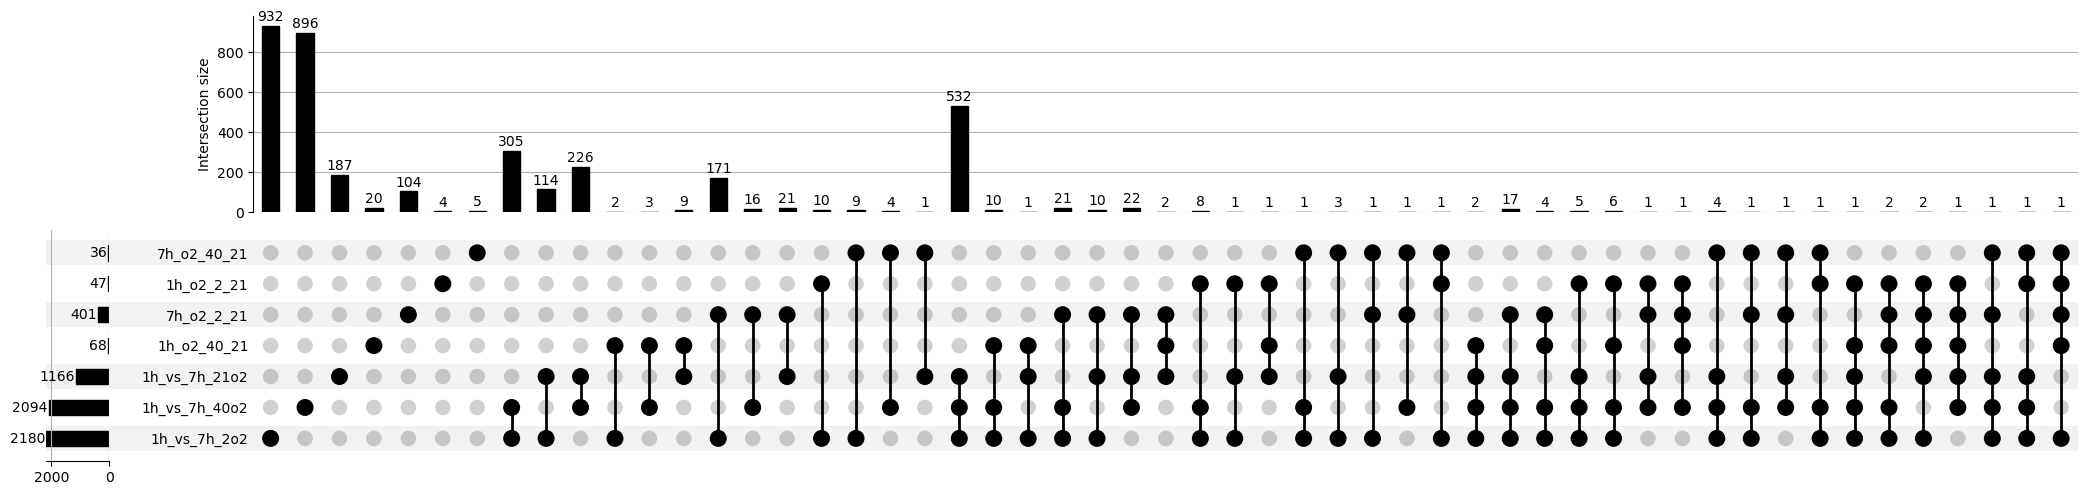

In [26]:
warnings.filterwarnings('ignore') 
to_plot = from_contents(genes_in_comps)
plot(to_plot, show_counts=True, sort_categories_by='input')

## GO enrichment
We want to see what GO terms are enriched in the various conditions. To do this, we'll use the command line tool from [GOAtools](https://github.com/tanghaibao/goatools/tree/main).

First, we need to format the genes from our conditions correctly:

In [51]:
comps_for_enrichment = all_comparisons
comps_for_enrichment.update(comps_filtered)
for comp, data in tqdm(comps_for_enrichment.items()):
    gene_list = '\n'.join(data.gene_id.tolist())
    with open(f'../data/gene_lists/{comp}_gene_list.txt', 'w') as f:
        f.write(gene_list)

100%|██████████| 9/9 [00:00<00:00, 312.24it/s]


We also need a list of all the genes in the A. thaliana genome to use for the reference part of the enrichment analysis. We'll do this by reading in the Tair to GO conversion file from the [TAIR GO resource](https://www.arabidopsis.org/download/list?dir=GO_and_PO_Annotations%2FGene_Ontology_Annotations):

In [12]:
# Manually copy the header names from the README file and apply them here
gene2GO_colnames = ['locus_name', 'TAIR_accession', 'object_name', 'relationship_type', 'GO_term', 'GO_ID', 'TAIR_Keyword_ID', 'Aspect', 'GOslim_term',
                    'Evidence_code', 'Evidence_description', 'Evidence_with', 'Reference', 'Annotator', 'Date_annotated']
gene2GO = pd.read_csv('../data/tair_go/ATH_GO_GOSLIM.txt', header=4, sep='\t', names=gene2GO_colnames, index_col=0)
gene2GO.head()

,TAIR_accession,object_name,relationship_type,GO_term,GO_ID,TAIR_Keyword_ID,Aspect,GOslim_term,Evidence_code,Evidence_description,Evidence_with,Reference,Annotator,Date_annotated
locus_name,,,,,,,,,,,,,,
AT1G01010,locus:2200935,AT1G01010,acts upstream of or within,regulation of DNA-templated transcription,GO:0006355,7461,P,nucleobase-containing compound metabolic process,ISS,none,NaN,Publication:1345963|PMID:11118137,NaN,2024-04-20
AT1G01010,locus:2200935,AT1G01010,enables,transcription cis-regulatory region binding,GO:0000976,35767,F,DNA binding,IPI,yeast one-hybrid assay,AGI_LocusCode:AT2G38290,Publication:501786139|PMID:30356219,sibrady,2020-12-18
AT1G01010,gene:2200934,AT1G01010.1,located in,nucleus,GO:0005634,537,C,nucleus,ISM,predicted protein features,NaN,AnalysisReference:501780126,rkaundal,2018-08-31
AT1G01010,locus:2200935,AT1G01010,involved in,regulation of DNA-templated transcription,GO:0006355,7461,P,other cellular processes,IEA,none,InterPro:IPR003441|InterPro:IPR036093,AnalysisReference:501756966,NaN,2024-04-19
AT1G01010,locus:2200935,AT1G01010,involved in,regulation of DNA-templated transcription,GO:0006355,7461,P,other metabolic processes,IEA,none,InterPro:IPR003441|InterPro:IPR036093,AnalysisReference:501756966,NaN,2024-04-19


Write out all the gene names to use as the reference list :

In [ ]:
with open('../data/gene_lists/reference_gene_list.txt', 'w') as f:
    f.write('\n'.join(list(set(gene2GO.TAIR_accession.tolist()))))

Now let's combine our gene lists with information from TAIR as well as the GO terms to save them out for manual viewing:

In [17]:
opposites_over_time = get_arabidopsis_descriptions(opposites_hour.gene_id.tolist(), gene2GO,  '../data/Araport11_functional_descriptions_20241231.txt')
opposites_over_time.to_csv('../data/gene_lists_with_descriptions/time_comparison_opposites.csv', index=True)

In [26]:
hour7_descriptions = get_arabidopsis_descriptions(opposites_hour7.gene_id.tolist(), gene2GO, '../data/Araport11_functional_descriptions_20241231.txt')
hour7_descriptions.to_csv('../data/gene_lists_with_descriptions/hour7_opposite_behavior_genes.csv', index=True)

In [32]:
all_comp_opposites = get_arabidopsis_descriptions(list(all_opposite), gene2GO, '../data/Araport11_functional_descriptions_20241231.txt')
all_comp_opposites.to_csv('../data/gene_lists_with_descriptions/all_comparisons_opposites.csv', index=True)

In [37]:
for comp, df in all_comparisons.items():
    desc = get_arabidopsis_descriptions(df.gene_id.tolist(), gene2GO, '../data/Araport11_functional_descriptions_20241231.txt')
    desc.to_csv(f'../data/gene_lists_with_descriptions/{comp}_DEGs_with_descriptions.csv', index=True)

Run the enrichment locally with GOAtools. We're going to make a loop in Python to run the command line for each of the comparisons.

In [ ]:
genelist_path = '../data/gene_lists'
for genelist in tqdm(listdir(genelist_path)):
    comp = splitext(genelist)[0]
    command = [
        'conda', 'run', '-n', 'omics',
        'python3', abspath('../data/find_enrichment.py'), abspath(f'{genelist_path}/{genelist}'), abspath('../data/gene_lists/reference_gene_list.txt'),  abspath('../data/tair_go/tair.gaf'),
        '--pval=0.05', '--method=fdr_bh', '--pval_field=fdr_bh', f'--outfile={abspath(f"../data/local_go_enrichments/{comp}_enrichments.xlsx")}', f'--obo={abspath("../data/go-basic.obo")}'
    ]
    subprocess.run(command)

Great! Now we need to read in the Excel files and process the results to plot them:

In [38]:
enrichment_results = {}
output_dir = '../data/local_go_enrichments'
for f in listdir(output_dir):
    df = pd.read_excel(f'{output_dir}/{f}')
    comp = '_'.join(splitext(f)[0].split('_')[:-3])
    enrichment_results[comp] = df

In [39]:
enrichments_to_plot = {
    comp: {go: len(genes.split(', ')) for go, genes in df[['GO', 'study_items']].set_index('GO').to_dict()['study_items'].items()}
    for comp, df in enrichment_results.items()
}
GO2semantic = {
    comp: df[['GO', 'name']].set_index('GO').to_dict()['name']
    for comp, df in enrichment_results.items()
}

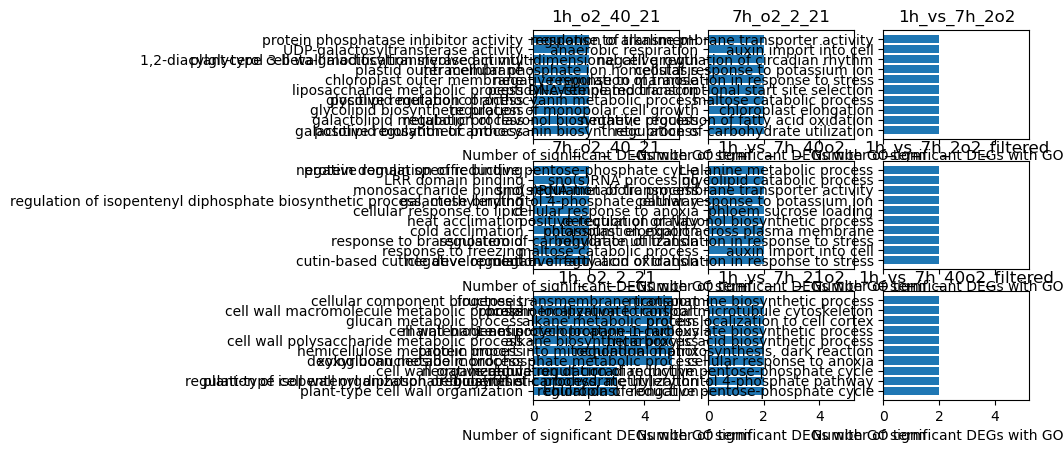

In [40]:
fig, axs = plt.subplots(3, 3, sharex=True)

for comp, ax in zip(enrichments_to_plot, axs.flat):

    # Sort from most to least and get semantic GO, only keep the top 10
    to_plot = {GO2semantic[comp][k]: v for k, v in sorted(enrichments_to_plot[comp].items(), key=lambda item: item[1])}
    to_plot = {k: to_plot[k] for i, k in enumerate(to_plot.keys()) if i < 10}
    ax.barh(to_plot.keys(), to_plot.values(), align='center')
    # ax.set_yticks(y_pos, labels=people)
    # ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Number of significant DEGs with GO term')
    ax.set_title(comp)